In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn.model_selection import KFold

In [2]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'


trainset = pd.read_csv('data/trainset.csv', index_col=0)
testset = pd.read_csv('data/testset.csv', index_col=0)

In [3]:
trainset.head(5)

,movie,year,runtime,director,stars,imdb,gross,metascore,vote,budget,...,stars_20,stars_21,stars_22,stars_23,stars_24,stars_25,stars_26,stars_27,stars_28,stars_29
5170,The Departure,2017.0,87.0,0,0,7.0,23100,85.0,154,0.0,...,0,0,0,0,0,0,0,0,0,0
5346,Every Day,2018.0,97.0,0,0,6.4,6102076,52.0,16170,4900000.0,...,0,0,0,0,0,0,0,0,0,0
3782,The Overnight,2015.0,79.0,0,0,6.1,1100000,65.0,15309,0.0,...,0,0,0,0,0,0,0,0,0,0
3937,Nasty Baby,2015.0,101.0,0,0,5.6,79800,64.0,2154,0.0,...,0,0,0,0,0,0,0,0,0,0
3108,Edge of Tomorrow,2014.0,113.0,0,0,7.9,100206256,71.0,571740,178000000.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
header = list(trainset)
y_train = trainset['gross']
y_test = testset['gross']

header.remove('gross')
header.remove('metascore')
header.remove('imdb')
header.remove('vote')
# header.remove('budget')
# header.remove('day')
# header.remove('month')

X_train = trainset.loc[:, header[1:]]
X_test = testset.loc[:, header[1:]]

In [5]:
print(X_train.shape)
print(X_test.shape)

(4165, 182)
(1785, 182)


In [6]:
model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

result=pd.DataFrame({'movie':testset['movie'] , 'label': y_test, 'prediction': [max(0,x) for x in prediction]})
r2 = r2_score(y_test, prediction)
print('r2_score: {}'.format(r2))

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

r2_score: 0.7724105859782618


In [7]:
result

,movie,label,prediction
4144,Dangal,12391761,4.470918e+06
2341,Tere Naal Love Ho Gaya,177472,1.685460e+06
708,Wake Up Sid,717977,2.849067e+06
4141,Miss Peregrine's Home for Peculiar Children,87242834,1.407045e+08
3516,3 Nights in the Desert,1279,0.000000e+00
...,...,...,...
2498,Greenwich Village: Music That Defined a Genera...,22560,3.019158e+05
1016,If I Die Tonight,20175,2.602204e+06
517,Jazz in the Diamond District,5107,4.077282e+04
4638,Guardians of the Galaxy Vol. 2,389813101,3.587103e+08


In [8]:
svc_rfr = cross_val_score(estimator=model,X=X_train,y=y_train,cv=KFold(n_splits=5), scoring='r2')
print(svc_rfr)
print(svc_rfr.mean())

[0.79460555 0.69011914 0.63048288 0.71228838 0.70356537]
0.7062122641706321


### Model tuning

In [10]:
# First round
model = XGBRegressor()
param = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=Non...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbos

0.7062122641706321
{'n_estimators': 100}


In [11]:
# Second round
model = XGBRegressor(n_estimators=100)
param = {'min_child_weight':[1,2,3,4,5,6]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=Non...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

0.7272580211872167
{'min_child_weight': 6}


In [12]:
# Third round
model = XGBRegressor(n_estimators=100, min_child_weight=6)
param = {'max_depth':[3,4,5,6,7,8,9,10, 15, 30, 50]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=6,
                                    m...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsam

0.7272580211872167
{'max_depth': 6}


In [13]:
# Fourth round
model = XGBRegressor(n_estimators=100, min_child_weight=6, \
                      max_depth=6)
param = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=6, min_child_weight=6,
                                    miss...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsam

0.7272580211872167
{'gamma': 0.1}


In [14]:
# Fifth round
# alpha : L1 regularization   lambda: L2 regularization
model = XGBRegressor(n_estimators=100, min_child_weight=6, \
                      max_depth=6, gamma=0.1)
param = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=0.1,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=6, min_child_weight=6,
                                    missi...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                

0.734011346492615
{'reg_alpha': 3, 'reg_lambda': 3}


In [15]:
# Sixth round
model = XGBRegressor(n_estimators=100, min_child_weight=6, \
                      max_depth=6, gamma=0.1,\
                      reg_alpha=3, reg_lambda=3)
param = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=0.1,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=6, min_child_weight=6,
                                    missi...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=3,
                                    reg_lambda=3, scale_pos_weight=None,
                                    subsample=No

0.7432710951487097
{'learning_rate': 0.1}


### Final Testing

In [16]:
# Final testing
model = XGBRegressor(n_estimators=100, min_child_weight=6, \
                      max_depth=6, gamma=0.1,\
                      reg_alpha=3, reg_lambda=3,\
                      learning_rate=0.1)

model.fit(X_train, y_train)
prediction = model.predict(X_test)

result=pd.DataFrame({'movie':testset['movie'] , 'label': y_test, 'prediction': [max(0,x) for x in prediction]})
r2 = r2_score(y_test, prediction)
print('r2_score: {}'.format(r2))

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=3,
             reg_lambda=3, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

r2_score: 0.7834656261617299


In [17]:
result

,movie,label,prediction
4144,Dangal,12391761,0.000000e+00
2341,Tere Naal Love Ho Gaya,177472,9.006631e+05
708,Wake Up Sid,717977,9.288540e+05
4141,Miss Peregrine's Home for Peculiar Children,87242834,8.367474e+07
3516,3 Nights in the Desert,1279,9.434510e+05
...,...,...,...
2498,Greenwich Village: Music That Defined a Genera...,22560,6.236660e+04
1016,If I Die Tonight,20175,1.828866e+06
517,Jazz in the Diamond District,5107,1.093315e+06
4638,Guardians of the Galaxy Vol. 2,389813101,2.611124e+08


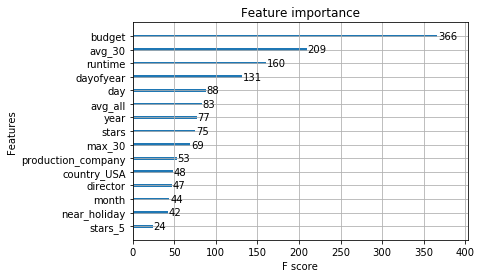

In [19]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=15)

### Save model

In [18]:
from sklearn.externals import joblib
joblib.dump(model, 'model.pkl')

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['model.pkl']

### Visualization

In [20]:
model = XGBRegressor(n_estimators=100, min_child_weight=6, \
                      max_depth=6, gamma=0.1,\
                      reg_alpha=3, reg_lambda=3,\
                      learning_rate=0.1)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, verbose=True, early_stopping_rounds=10)

[0]	validation_0-mae:20232956.00000	validation_1-mae:18435238.00000
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:18624074.00000	validation_1-mae:17082974.00000
[2]	validation_0-mae:17253784.00000	validation_1-mae:15923191.00000
[3]	validation_0-mae:16091492.00000	validation_1-mae:15035745.00000
[4]	validation_0-mae:15127034.00000	validation_1-mae:14239807.00000
[5]	validation_0-mae:14323577.00000	validation_1-mae:13686139.00000
[6]	validation_0-mae:13600418.00000	validation_1-mae:13157965.00000
[7]	validation_0-mae:12959276.00000	validation_1-mae:12726560.00000
[8]	validation_0-mae:12436859.00000	validation_1-mae:12324779.00000
[9]	validation_0-mae:12021793.00000	validation_1-mae:12087930.00000
[10]	validation_0-mae:11666433.00000	validation_1-mae:11838491.00000
[11]	validation_0-mae:11279172.00000	validation_1-mae:11662983.00000
[12]	validation_0-mae:109

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=3,
             reg_lambda=3, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [21]:
results = model.evals_result()

In [22]:
epochs = len(results['validation_0']['mae'])

Text(0, 0.5, 'Regression Error')

Text(0.5, 1.0, 'XGBoost Regression Error')

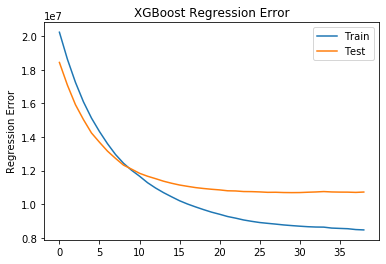

In [23]:
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('Regression Error')
plt.title('XGBoost Regression Error')
plt.show()